# Benchmark ComBind on PDB ligands

In [1]:
import os
import numpy as np
from glob import glob
from benchmark import benchmark, load_chembl
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = load_chembl('stats6', 'best_mcss')

SLC6A4
BRAF
PYGM
SMO
AR
VDR
MEK1
5HT2B
F11
P00760
CDK2
JAK2
BACE1
ERA
DAT
BRD4
A2AR
PLK1
PTPN1
GLUT1
MGLUR5
PLAU
B2AR
F2
TRPV1
F10
NR3C2
ELANE
NR3C1
MAPK14
HSP90AA1
PDE10A
B1AR
CHK1


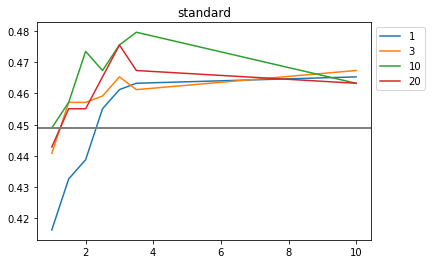

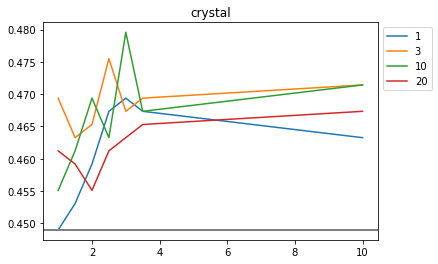

In [3]:
def performance(results):
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]
    return (sum(x) / float(len(x)), sum(np.array(x) <= 2.0) /  float(len(x)),
            sum(y) / float(len(y)), sum(np.array(y) <= 2.0) /  float(len(y)))

def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factors = sorted(set(k[1] for k in data[mode].keys()))
    for n in [1, 3, 10, 20]: #num_ligs:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [performance(data[mode][(n, alpha_factor, feature)])]
        plt.plot(alpha_factors, [p[3] for p in performances], label = n)
        for p in performances:
            plt.axhline(p[1], c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'mcss_pipi_contact_hbond_sb')
sweep(data, 'crystal', 'mcss_pipi_contact_hbond_sb')

490 valid ligands
Ttest_relResult(statistic=2.1806875724946089, pvalue=0.029682412023569412)
ComBind improves pose for 92 of 490 ligands
ComBind degrades pose for 64 of 490 ligands
All Ligands RMSD Glide: 3.94508163833, 0.448979591837
All Ligands RMSD ComBind: 3.75256267215, 0.459183673469


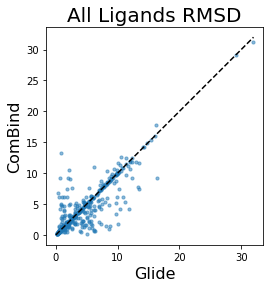

Mean RMSD Glide: 3.83403364747
Mean RMSD ComBind: 3.65238011506


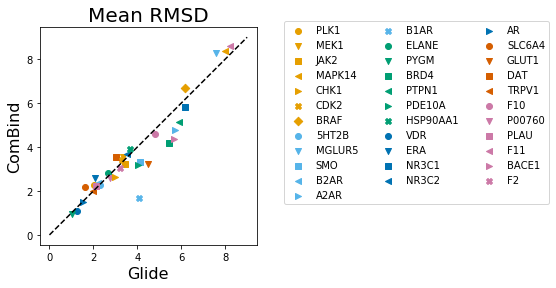

Fraction Near-Native Glide: 0.453717397078
Fraction Near-Native ComBind: 0.460802958575


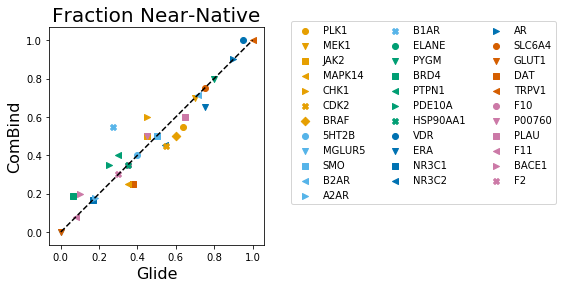

In [3]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')])